<span style="font-family:TimesNewRoman; font-size:2.5em; font-weight: bold;">
    Notes
</span>


<br>

<span style="font-family:TimesNewRoman; font-size:1em;">
Increasing both the batch size and the encoding dimension increased the clarity of the output images but the encoding dimension had a more significant increase.  
<br>
Increasing the hidden dimension has more of an impact on clarity than increasing the encoding dimension. But, it is slower as it is a higher number to begin with. Increasing it at all increases the number of calculations required by a more significant amount than increasing the encoding dimension. This is because the encoding dimension is a lot smaller. 
<br>
The accuracy does not seem to improve much after 10 epochs and as it is quite slow, I left it at that.
<br>
Increasing or decreasing the learning rate by orders of magnitude causes the loss to increase and decreases the clarity of the reproduced images.
<br>
The c
</span>



# Setup

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 for all logs, 2 for errors only
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## structure data as needed

In [115]:
mnist = keras.datasets.mnist

In [116]:
mnist

<module 'keras.api._v2.keras.datasets.mnist' from '/Users/nadinecallan/opt/anaconda3/lib/python3.9/site-packages/keras/api/_v2/keras/datasets/mnist/__init__.py'>

In [117]:
(x_train, _), (x_test, _) = mnist.load_data()

In [118]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_train.max())
print(x_test.shape)
print(x_test.max())

(60000, 784)
1.0
(10000, 784)
1.0


# Neural Network

batch_size_16_encoding_dim_64

In [119]:
encoding_dim = 64
hidden_dim = 128
batch_size = 16
epochs = 30
learning_rate = 0.001

factor = 0.1
patience = 1
min_lr = 0.00001
verbose = 1

In [120]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor,
                              patience=patience, min_lr=min_lr, verbose=verbose)

## Autoencoder

### Input

In [121]:
# input layer has 784 neurons (fixed values according to input)
input_img = keras.Input(shape=(784,))

### Encoder

In [122]:
encoded = layers.Dense(hidden_dim, activation='relu')(input_img)
encoded1 = layers.Dense(hidden_dim, activation='relu')(encoded)
encoded2 = layers.Dense(hidden_dim, activation='relu')(encoded1)

### Bottleneck

In [123]:
# bottleneck layer has 32 neurons (encoding dim)
bottleneck = layers.Dense(encoding_dim, activation='relu')(encoded2)

### Decoder

In [124]:
decoded = layers.Dense(hidden_dim, activation='relu')(bottleneck)
decoded1 = layers.Dense(hidden_dim, activation='relu')(decoded)
decoded2 = layers.Dense(hidden_dim, activation='relu')(decoded1)

### Output

In [125]:
# output layer has 784 neurons (should be set to be same as input as trying to recreate it)
output_img = layers.Dense(784, activation='sigmoid')(decoded2)

In [126]:
autoencoder = keras.Model(input_img, output_img)

In [127]:
encoder = keras.Model(input_img, bottleneck)

In [128]:
encoded_input = keras.Input(shape=(encoding_dim,))

In [129]:
decoder_input = keras.Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-4](decoder_input)
decoder = autoencoder.layers[-3](decoder)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)

In [130]:
decoder_model = keras.Model(decoder_input, decoder)

In [131]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='binary_crossentropy')

## training the model

In [132]:
fitting_output = autoencoder.fit(x_train, x_train, 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 validation_data=(x_test, x_test),
                                 callbacks=[reduce_lr])

Epoch 1/30
3750/3750 [==============================] - 10s 2ms/step - loss: 0.1446 - val_loss: 0.1150 - lr: 0.0010
Epoch 2/30
3750/3750 [==============================] - 9s 2ms/step - loss: 0.1090 - val_loss: 0.1026 - lr: 0.0010
Epoch 3/30
3750/3750 [==============================] - 9s 2ms/step - loss: 0.1013 - val_loss: 0.0973 - lr: 0.0010
Epoch 4/30
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0970 - val_loss: 0.0941 - lr: 0.0010
Epoch 5/30
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0943 - val_loss: 0.0926 - lr: 0.0010
Epoch 6/30
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0922 - val_loss: 0.0911 - lr: 0.0010
Epoch 7/30
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0905 - val_loss: 0.0894 - lr: 0.0010
Epoch 8/30
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0891 - val_loss: 0.0872 - lr: 0.0010
Epoch 9/30
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0

In [133]:
training_history = fitting_output.history

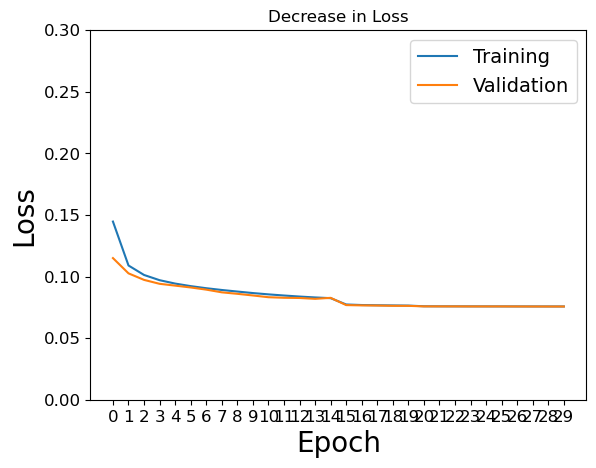

In [134]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['loss'], label='Training')
ax.plot(fitting_output.history['val_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_xticks(np.arange(0, epochs, 1))
ax.set_ylim(0, 0.3)
plt.show()

## testing the model

In [135]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [136]:
x_test.shape

(10000, 784)

In [137]:
encoded_imgs = encoder.predict(x_test)

313/313 [==============================] - 0s 997us/step


In [138]:
encoded_imgs[1]

array([ 0.       ,  5.77417  ,  9.344878 ,  4.422649 , 11.097612 ,
        0.       ,  3.051536 ,  3.2090068, 10.011474 ,  4.379154 ,
        7.780194 ,  0.       ,  0.       ,  2.747033 ,  7.7212133,
        0.       ,  5.538074 ,  4.3654003,  0.       ,  0.       ,
        2.5892518,  1.13634  ,  3.5670624,  0.       ,  8.3322735,
        7.829987 ,  5.4422865,  2.4331355,  0.       ,  1.8063627,
        1.5427134,  6.4073496,  1.1892543,  0.       ,  6.004898 ,
        5.354197 ,  5.225171 ,  0.       ,  3.3385236,  4.432184 ,
        4.961765 ,  8.771732 ,  4.928161 ,  8.34446  ,  0.       ,
        0.       ,  3.3871918,  9.808772 ,  8.140373 ,  0.       ,
        0.       ,  4.376315 ,  3.627135 ,  5.528159 ,  3.5369556,
        0.       ,  0.       ,  1.0844516,  6.457632 ,  0.       ,
        0.       ,  1.7174778,  6.4743047,  4.486549 ], dtype=float32)

In [139]:
decoded_imgs = decoder_model.predict(encoded_imgs)
decoded_imgs = decoded_imgs.reshape(-1, 28, 28)

313/313 [==============================] - 0s 1ms/step


In [140]:
num_images, width, height = decoded_imgs.shape

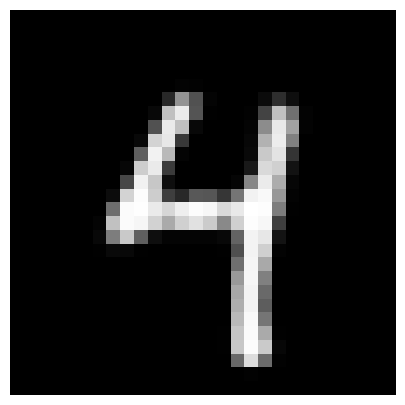

In [141]:
fig = plt.figure(figsize=(10, 5))

plt.imshow(decoded_imgs[4576], cmap='gray')
plt.axis('off')

#plt.tight_layout()
plt.show()

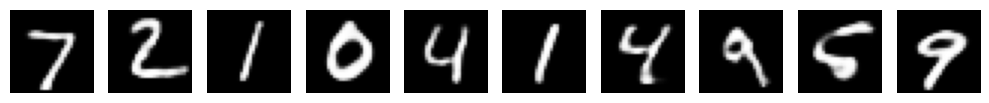

In [142]:
fig = plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(decoded_imgs[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [143]:
user_input = input("Image Title: ")

Image Title: a


In [144]:
name = f'{user_input}'

plots_folder_name = 'created_images'
plots_file_name = f'{name}.png'
plots_folder_path = f'output_data/{plots_folder_name}'
os.makedirs(plots_folder_path, exist_ok=True)
plots_file_path = os.path.join(plots_folder_path, plots_file_name)
#fig.savefig(plots_file_path)
plt.show

print(name)

a


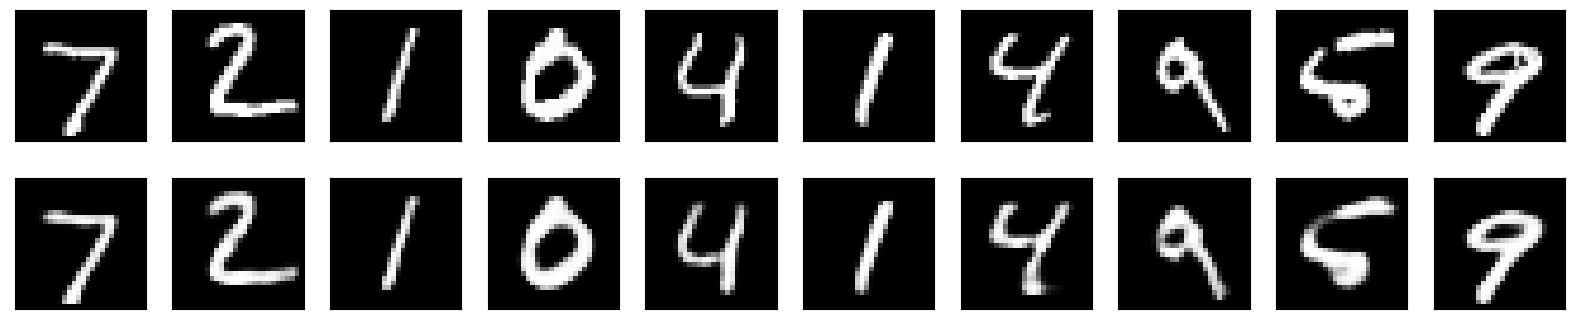

In [145]:
n = 10 
fig = plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

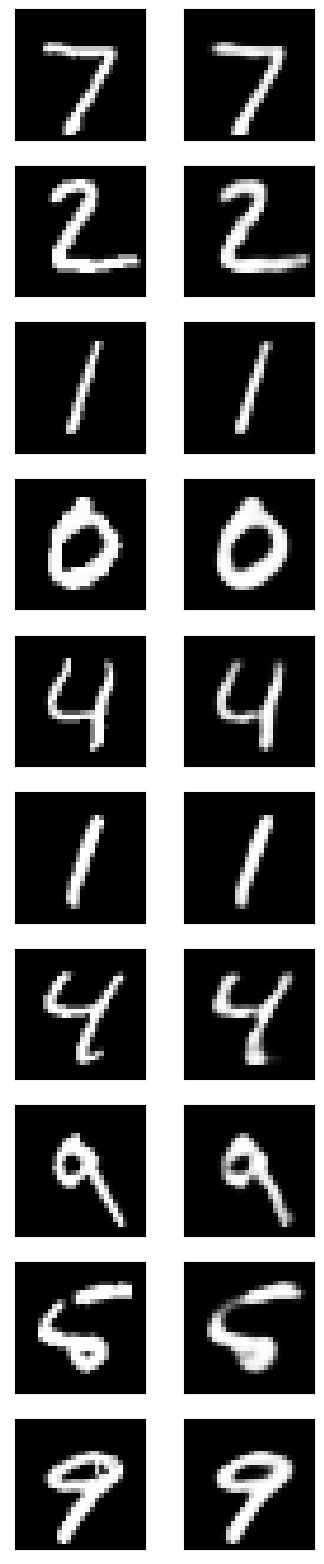

In [148]:
n = 10

fig = plt.figure(figsize=(4, 20))
for i in range(n):
    ax = plt.subplot(n, 2, i * 2 + 1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n, 2, i * 2 + 2)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('autoencoder_input_output')
plt.show()

In [ ]:
# run = f'batch_size_{batch_size}_encoding_dim_{encoding_dim}_hidden_dim_{hidden_dim}_epochs_{epochs}_lr_{learning_rate}_layers_7'

# plots_folder_name = 'plots_of_output_data'
# plots_file_name = f'{run}.png'
# plots_folder_path = f'output_data/{plots_folder_name}'
# os.makedirs(plots_folder_path, exist_ok=True)
# plots_file_path = os.path.join(plots_folder_path, plots_file_name)
# fig.savefig(plots_file_path)
# plt.show

# print(run)